# Predicting Loan Default 4 - Evaluation

In this notebook we evaluate our models performance on the unseen training data and conclude our project. 

## Preamble

### Packages

In [11]:
## data handling  
import pandas as pd

## visualization
import matplotlib.pyplot as plt
import seaborn as sns

## sklearn models
from sklearn.metrics import (classification_report, accuracy_score, 
                             roc_auc_score, RocCurveDisplay)

## pickle 
from pickle import load

## get file path of the data
from private import FINAL_FILE_PATH

### Data

In [2]:
## load datasets
X_train = pd.read_csv(FINAL_FILE_PATH + "X_train.csv", index_col=0)
X_test = pd.read_csv(FINAL_FILE_PATH + "X_test.csv", index_col=0)
y_train = pd.read_csv(FINAL_FILE_PATH + "y_train.csv", index_col=0)
y_test = pd.read_csv(FINAL_FILE_PATH + "y_test.csv", index_col=0)

### Models

In [3]:
rf = load(open("../models/rf_model.p", "rb" ))
gbm = load(open("../models/gbm_model.p", "rb" ))
nn = load(open("../models/nn_model.p", "rb" ))

## Evaluating Models on the Test Set

We use recall and accuracy as our main metrics for evaluating the models performance. We will also look into feature importance.

### Random Forest 

Accuracy of RF = 0.8975674640423283
              precision    recall  f1-score   support

           0       0.92      0.96      0.94    190617
           1       0.80      0.65      0.71     46954

    accuracy                           0.90    237571
   macro avg       0.86      0.80      0.83    237571
weighted avg       0.89      0.90      0.89    237571

ROC Score of RF = 0.8030863333894934


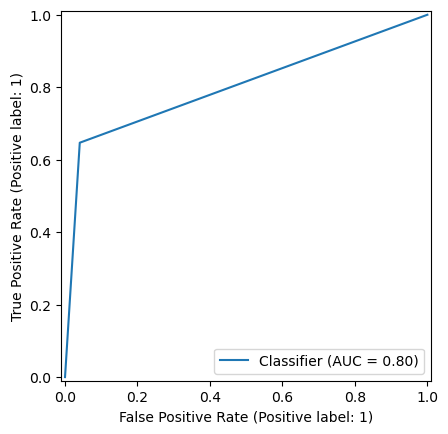

In [13]:
rf_pred = rf.predict(X_test)
rf_score = accuracy_score(y_test, rf_pred)
rf_probs = rf.predict_proba(X_test)
rf_roc = roc_auc_score(y_test, rf_pred)

print(f"Accuracy of RF = {rf_score}")
print(classification_report(y_test, rf_pred))
print(f"ROC Score of RF = {rf_roc}")
RocCurveDisplay.from_predictions(y_test, rf_pred)

We suspected the random forest was overfit to the training data, and the performance on the test set seems to confirm this. The accuracy has taken a significant drop (0.99 down to 0.90) and the recall is very low (0.65). The random forest is showing unstable performance and therefore would not be recommended for deployment. With more processing power and time, we could try to tune more parameters on the training set (such as max_depth) and increase the number of estimators to reduce overfitting. 

### Gradient Boosted Machine

Accuracy of GBM = 0.9284129796987006
              precision    recall  f1-score   support

           0       0.95      0.96      0.96    190617
           1       0.84      0.79      0.81     46954

    accuracy                           0.93    237571
   macro avg       0.89      0.87      0.88    237571
weighted avg       0.93      0.93      0.93    237571

ROC Score of GBM = 0.8746514724722594


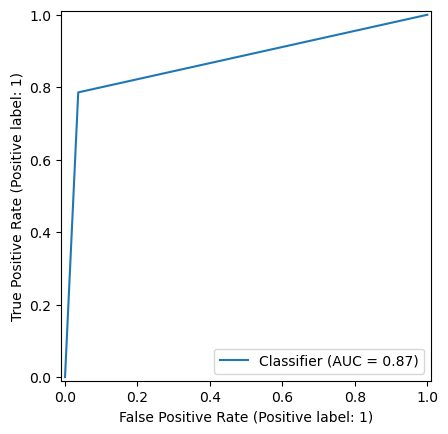

In [14]:
gbm_pred = gbm.predict(X_test)
gbm_score = accuracy_score(y_test, gbm_pred)
gbm_probs = gbm.predict_proba(X_test)
gbm_roc = roc_auc_score(y_test, gbm_pred)

print(f"Accuracy of GBM = {gbm_score}")
print(classification_report(y_test, gbm_pred))
print(f"ROC Score of GBM = {gbm_roc}")
RocCurveDisplay.from_predictions(y_test, gbm_pred)

The gradient boosted machine has shown the most stable and accurate performance, with results largely consistent with that of the training set. The GBM still has a lower recall than we would like (0.79). As we would like high recall, we could consider bagging the training data to rebalance the default categories and see if that improves the recall of GBM. Overall, with its stable performance and relatively high accuracy and recall, we would (with some optimizations) recommend this model for deployment.  

### Multi-Layer Perceptron

Accuracy of NN = 0.8996047497379731
              precision    recall  f1-score   support

           0       0.92      0.96      0.94    190617
           1       0.79      0.67      0.72     46954

    accuracy                           0.90    237571
   macro avg       0.86      0.81      0.83    237571
weighted avg       0.90      0.90      0.90    237571

ROC Score of NN = 0.812485887556378


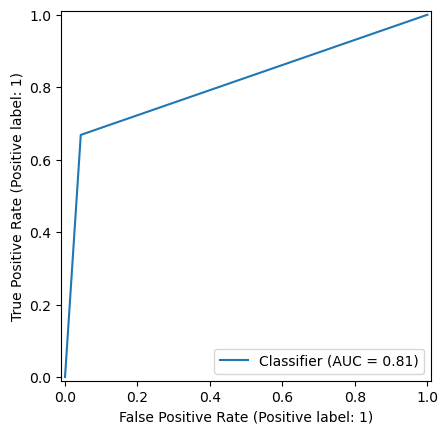

In [15]:
nn_pred = nn.predict(X_test)
nn_score = accuracy_score(y_test, nn_pred)
nn_probs = nn.predict_proba(X_test)
nn_roc = roc_auc_score(y_test, nn_pred)

print(f"Accuracy of NN = {nn_score}")
print(classification_report(y_test, nn_pred))
print(f"ROC Score of NN = {nn_roc}")
RocCurveDisplay.from_predictions(y_test, nn_pred)

The multi-layer perceptron has performed consistently, though has suffered significantly from the imbalanced categories. We could use bagging to balance the default categories on the training set, as well as try to change the activation function in order to increase recall. The stable performance shows that the model could be a good predictor with some improvements, but the low recall means we would not at this time recommend this model for deployment. 

## Feature Importance

We now analyze which features are having the greatest effect on our models and are therefore likely to be the best predictors of credit default. 

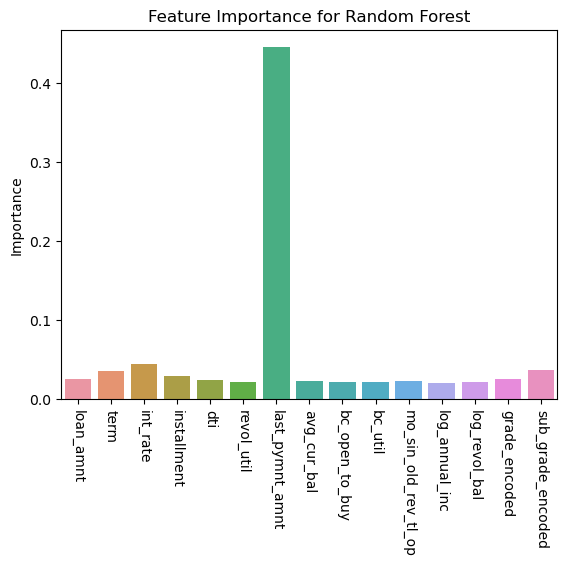

In [30]:
rf_imp = pd.DataFrame(rf.feature_importances_, 
                      index=rf.feature_names_in_, 
                      columns=["Importance"])
rf_imp2 = rf_imp[rf_imp.Importance > 0.02]
sns.barplot(data = rf_imp2, y="Importance", x=rf_imp2.index)
plt.xticks(rotation=-90)
plt.title("Feature Importance for Random Forest");

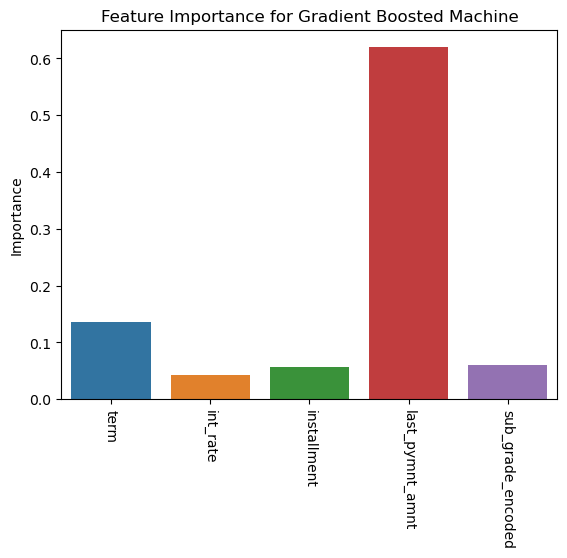

In [31]:
gbm_imp = pd.DataFrame(gbm.feature_importances_, 
                      index=gbm.feature_names_in_, 
                      columns=["Importance"])
gbm_imp2 = gbm_imp[gbm_imp.Importance > 0.02]
sns.barplot(data = gbm_imp2, y="Importance", x=gbm_imp2.index)
plt.xticks(rotation=-90)
plt.title("Feature Importance for Gradient Boosted Machine");

We see that `last_pymnt_amnt` is the overwhelming feature in both the random forest and gradient boosted models. It appears that this feature contributes a vast weight to our predictions. In order of importance, we have: 

- `last_pymnt_amnt`
- `sub_grade`
- `term`
- `int_rate`

This suggests that for predicting loan default, one should keep close track of these features, which are all available to a lender at the point of prediction. 

Note it is difficult to determine feature importances from the multi-layer-perceptron, so we do not include that here. 

## Conclusion 

To summarize, we have found that a gradient boosted model was the most consistent, stable and accurate performer on the unseen data, and with some further adjustments could be a strong predictor of loan default. 

We also found that the last amount paid, the sub grade of the loan, the term of the loan and the interest rate are key features for predicting whether a borrower will default on their loan. 